In [1]:
%matplotlib inline  

import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from helpers import plots

try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


#### Load model

In [2]:
model = load_model('../models/brats_3ch_model_2.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
_________________________________________________________________
max_c (MaxPooling2D)         (None, 30, 30, 64)        0         
__________

#### Load images

In [4]:
train_dir = '../data/train/t2_t1ce_flair'
valid_dir = '../data/valid/t2_t1ce_flair'
batch_size = 256
IMG_HEIGHT = 240
IMG_WIDTH = 240
train_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)
train_gen = train_generator.flow_from_directory(batch_size=batch_size,
                                       directory=train_dir,
                                       shuffle=True,
                                       color_mode="rgb",
                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                       class_mode='categorical')

val_gen = val_generator.flow_from_directory(batch_size=batch_size,
                                       directory=valid_dir,
                                            shuffle=True,
                                       color_mode="rgb",
                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                       class_mode='categorical')

Found 13440 images belonging to 2 classes.
Found 3360 images belonging to 2 classes.


In [5]:
x, y = next(val_gen)

[0, 1, 1, 1, 1]


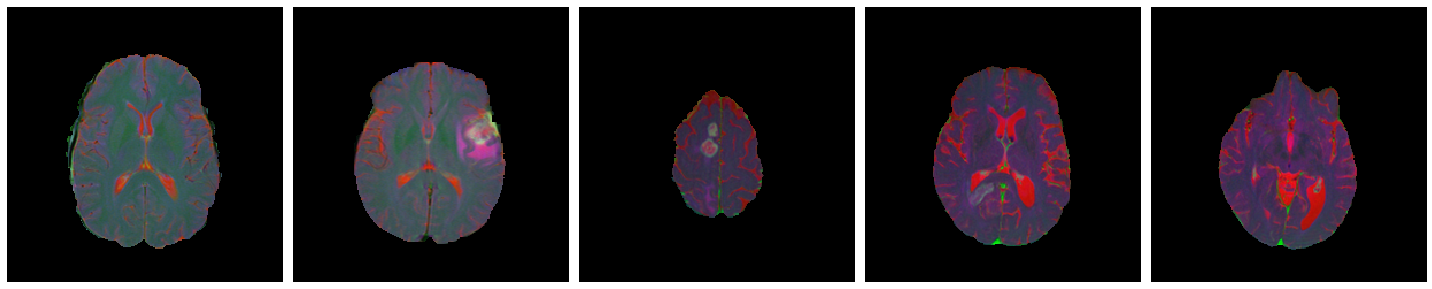

In [6]:
print([np.argmax(i) for i in y[:5]])
plots.plot_rgb_images(x[:5])

#### Prepare analyzer

In [7]:
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

#### Analyze

In [8]:
def input_postprocessing(X):
    return X

def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X

def bk_proj(X):
    return ivis.graymap(X)

def heatmap(X):
    return ivis.heatmap(X)

def graymap(X):
    return ivis.graymap(np.abs(X))

input_range = [0, 1]
noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]
methods = [
    # Function
    ("gradient",              {"postprocess": "abs"},   graymap,        "Gradient"),
    ("smoothgrad",            {}                       ,graymap,        "SmoothGrad"),
    # Signal
    ("deconvnet",             {},                       bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       bk_proj,        "Guided Backprop",),
    # Interaction
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, heatmap,        "DeepTaylor"),
    ("input_t_gradient",      {},                       heatmap,        "Input * Gradient"),
    ("integrated_gradients",  {"reference_inputs": ri}, heatmap,        "Integrated Gradients"),
    ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon"),
]

In [9]:
# Create analyzers.
analyzers = []
for method in methods:
    print(method[3])
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    analyzers.append(analyzer)

Gradient
SmoothGrad
Deconvnet
Guided Backprop
DeepTaylor
Input * Gradient
Integrated Gradients
LRP-Z
LRP-Epsilon


In [10]:
n = 5
val_images, val_labels = next(val_gen)
test_images = list(zip(val_images[:n], val_labels[:n]))

analysis = np.zeros([len(test_images), len(analyzers), 240, 240])
for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    for aidx, analyzer in enumerate(analyzers):
        a = analyzer.analyze(x)
        img = a[0]
        img = img.sum(axis=np.argmax(np.asarray(img.shape) == 3))
        img /= np.max(np.abs(img))
        analysis[i, aidx] = img


<Figure size 432x288 with 0 Axes>

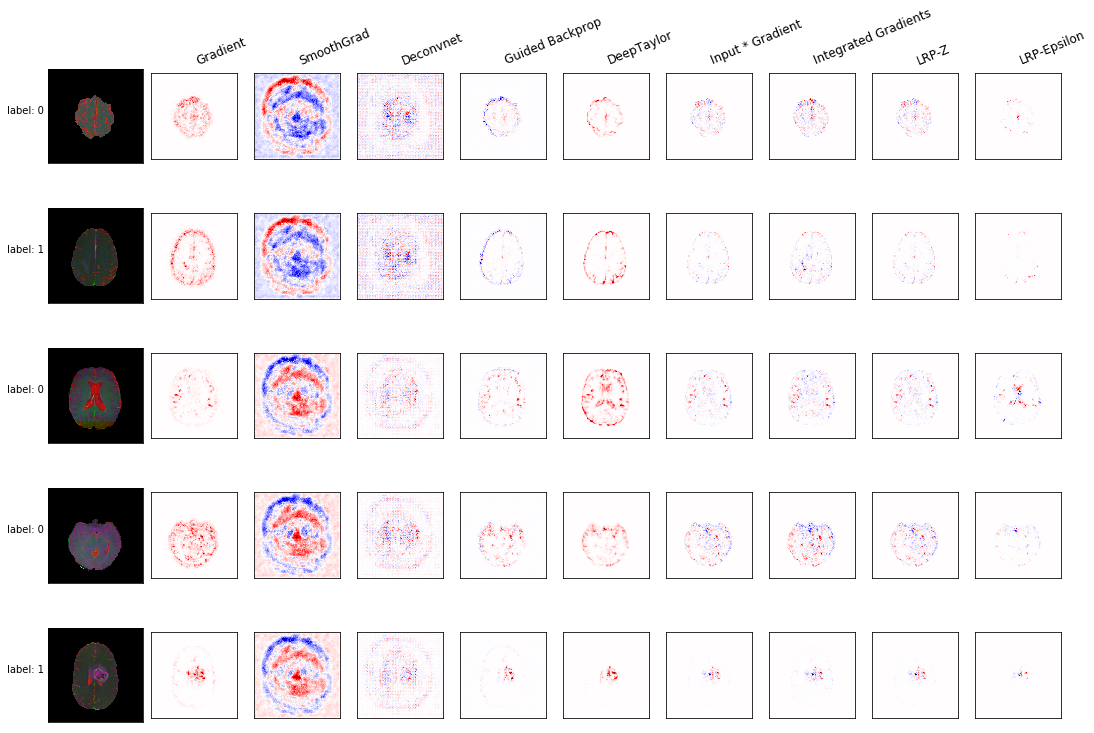

In [11]:
def get_label(l):
    return np.argmax(l)

# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# # Prepare the labels
# label, presm, prob, pred = zip(*text)
row_labels_left = [['label: {}'.format(get_label(l))] for l in val_labels[:n]]
# row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

plots.plot_image_grid(val_images[:n],grid,row_labels_left,[],col_labels,figsize=(20,15))